I'm starting to work on the emulator. I'm getting a simple one off the ground, and working out the kinks here.

In [14]:
from glob import glob
from itertools import cycle
import os
import numpy as np
from scipy.linalg import block_diag
import george
from george.kernels import *
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [15]:
directory = '/u/ki/swmclau2/des/HODOutput/chinchilla_step_tests/'
files = sorted(glob(os.path.join(directory, 'corr_1.000_redMagic_mm_*.npy')))
cov_files = sorted(glob(os.path.join(directory, 'cov_1.000_redMagic_mm_*.npy')))
used_files = files[1::2]#only use half to train, for now. 
u_cov_files = cov_files[1::2]

First, plot the data. 

In [16]:
x,y,yerr = [],[],[]
plot_y = {}
plot_yerr = {}
masses = set()
covs = []
num_used = 0
for f,cf in zip(used_files, u_cov_files):
    print f
#for f in used_files:
    data = np.loadtxt(f)
    cov = np.loadtxt(cf)
                
    basename = os.path.basename(f)
    mass = float(basename.split('_')[-1][:-4]) #mess of parsing to get the mass
    
    if np.any(np.isnan(cov)):
        for i, row in enumerate(cov):
            for j, item in enumerate(row):
                if np.isnan(item):
                    cov[i,j] = max(data[1,i], data[1,j])*0.1 #just get rid of NaNs for now
    
    masses.add(mass)
    
    for r, xi in data.T:
        x.append([mass, np.log10(r)])
        y.append(np.log10(xi)) 
        #x.append([mass, r])
        #y.append(xi)
    plot_y[mass] = data.T[:,1]
    plot_yerr[mass] = np.sqrt(np.diag(cov))
    
    covs.append(cov/((np.log(10)**2)*np.outer(data.T[:,1],data.T[:,1])))
    num_used+=1
    yerr.extend(np.sqrt(np.diag(cov))/(data.T[:,1]*np.log(10)))#not sure this is statistically viable
    #also think I need a factor of 10 somewhere
    #yerr.extend(np.sqrt(np.diag(cov)))#not sure this is statistically viable
print num_used
x,y,ycov = np.array(x), np.array(y), block_diag(*covs)
#x,y = np.array(x), np.array(y)

/u/ki/swmclau2/des/HODOutput/chinchilla_step_tests/corr_1.000_redMagic_mm_12.25.npy
/u/ki/swmclau2/des/HODOutput/chinchilla_step_tests/corr_1.000_redMagic_mm_12.75.npy
/u/ki/swmclau2/des/HODOutput/chinchilla_step_tests/corr_1.000_redMagic_mm_13.25.npy
/u/ki/swmclau2/des/HODOutput/chinchilla_step_tests/corr_1.000_redMagic_mm_13.75.npy
4


In [17]:
print x.shape, y.shape, ycov.shape

(72, 2) (72,) (72, 72)


In [18]:
from scipy.linalg import det, eigvals
print det(ycov)
for i in xrange(4):
    print det(ycov[i*18:(i+1)*18,i*18:(i+1)*18 ])
    print eigvals(ycov[i*18:(i+1)*18,i*18:(i+1)*18 ])

-0.0
7.85924741942e-100
[  9.12198022e-04+0.j   4.59194147e-05+0.j   3.76392582e-05+0.j
   2.29562370e-05+0.j   1.91220982e-05+0.j   7.05209867e-06+0.j
   3.97609422e-06+0.j   3.18078260e-06+0.j   1.78832485e-06+0.j
   1.69320827e-06+0.j   9.85370807e-07+0.j   8.77204061e-07+0.j
   7.36309896e-07+0.j   5.21526113e-07+0.j   2.44181899e-07+0.j
   3.06409382e-07+0.j   3.68909170e-07+0.j   4.58965843e-07+0.j]
3.3113815411e-93
[  8.62739392e-04+0.j   5.71771162e-04+0.j   8.99819606e-05+0.j
   7.89024309e-05+0.j   2.80974527e-05+0.j   2.10649512e-05+0.j
   1.37607874e-05+0.j   8.09927363e-06+0.j   4.67183847e-06+0.j
   2.89179483e-06+0.j   2.59387431e-06+0.j   1.59133256e-06+0.j
   4.08086429e-07+0.j   1.27514285e-06+0.j   5.97526536e-07+0.j
   7.83067134e-07+0.j   1.12484638e-06+0.j   9.38467367e-07+0.j]
5.04059902976e-87
[  1.26855527e-03+0.j   9.82362600e-04+0.j   6.36031975e-04+0.j
   1.05622994e-04+0.j   7.63115744e-05+0.j   2.85196778e-05+0.j
   2.41464646e-05+0.j   1.47128630e-05+0.j 

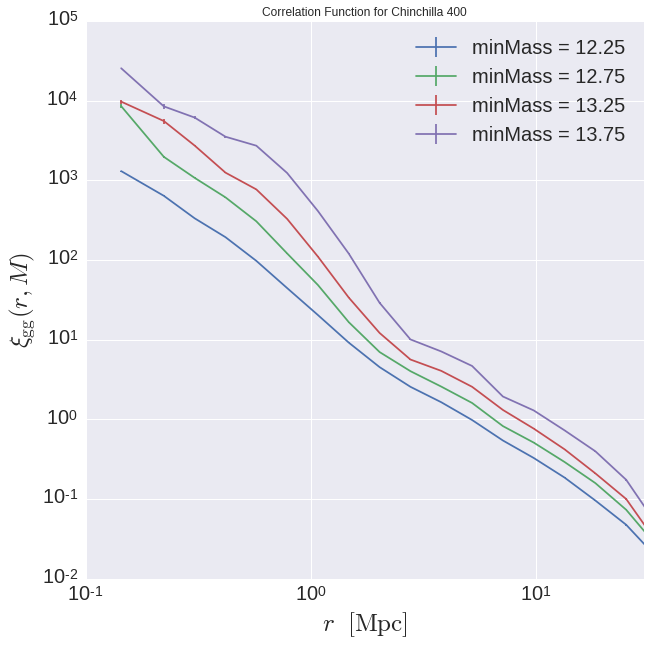

In [19]:
fig = plt.figure(figsize = (10, 10))
plt.clf()
colors = cycle(sns.color_palette())
r = data.T[:,0]# r values

for (mass, xi), color  in zip(sorted(plot_y.iteritems(), key = lambda x: x[0]), colors):
    plt.errorbar(r,xi,yerr=plot_yerr[mass], label = 'minMass = %.2f'%mass, color = color)
        
plt.xlim(xmin = 0.1, xmax = 30)
plt.ylim(ymin = 1e-2, ymax = 1e5)
plt.title("Correlation Function for Chinchilla 400")
plt.loglog()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.ylabel(r'$\xi_{\rm gg}(r, M)$', fontsize=25)
plt.legend(loc='best', fontsize=20)  

plt.show()

In [20]:
from time import time
np.random.seed(int(time()))
metric = (2,0.1) #variance in each dimension of the kernel. Don't understand its use entirely, yet.
a = 1e5
kernel = a*ExpSquaredKernel(metric, ndim = 2)
gp = george.GP(kernel)
print np.exp(gp.kernel.vector)
gp.compute(x, np.sqrt(np.diag(ycov) ) )
print gp.lnlikelihood(y-y.mean()), y.mean()

[  1.00000000e+05   2.00000000e+00   1.00000000e-01]
-209.504852251 1.13474064511


In [21]:
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    # Update the kernel parameters and compute the likelihood.
    #params are log(a) and log(m)
    gp.kernel[:] = p
    ll = gp.lnlikelihood(y, quiet=True)

    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.kernel[:] = p
    return -gp.grad_lnlikelihood(y, quiet=True)

# You need to compute the GP once before starting the optimization.
#gp.compute(t)

# Print the initial ln-likelihood.
print(gp.lnlikelihood(y))

# Run the optimization routine.
p0 = gp.kernel.vector
results = op.minimize(nll, p0, jac=grad_nll)
print results
print np.exp(results.x)

# Update the kernel and print the final log-likelihood.
gp.kernel[:] = results.x
print(gp.lnlikelihood(y))

-209.50510652
      fun: -7.29435343691874
 hess_inv: array([[ 0.08756697,  0.02327788,  0.01164325],
       [ 0.02327788,  0.02236491,  0.00040446],
       [ 0.01164325,  0.00040446,  0.00451613]])
      jac: array([ -5.90256002e-06,   2.30439483e-06,  -6.34638134e-06])
  message: 'Optimization terminated successfully.'
     nfev: 20
      nit: 14
     njev: 20
   status: 0
  success: True
        x: array([ 0.8399689 , -0.39705683, -2.81939715])
[ 2.31629495  0.67229582  0.05964189]
7.29435343692


For numerical stability you need to have the yerr's. 

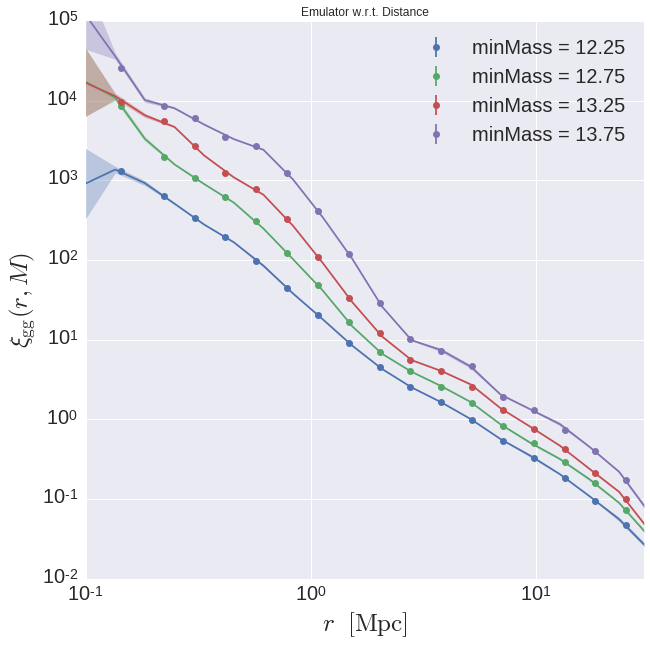

In [22]:
fig = plt.figure(figsize = (10, 10))
plt.clf()
colors = cycle(sns.color_palette())
N = 20
dense_r = np.logspace(-1,1.5, N)
for (mass, xi), color  in zip(sorted(plot_y.iteritems(), key = lambda x: x[0]), colors):

    plt.errorbar(r,xi,yerr=plot_yerr[mass], label = 'minMass = %.2f'%mass, color = color, fmt = 'o')

    t = np.stack([np.ones(N)*mass,np.log10(dense_r) ]).T
     
    #t = np.stack([np.ones(N)*mass,dense_r ]).T
    y_hat = 0
    mu, cov = gp.predict(y-y_hat, t)
    std = np.sqrt(np.diag(cov))
    #plt.errorbar(dense_r, 10**(mu+y_hat), yerr = std, color = color)
    #plt.errorbar(dense_r, (mu+y_hat), yerr = std, color = color)
    
    plt.plot(dense_r, 10**(mu+y_hat), color = color)
    plt.fill_between(dense_r,10**(mu+y_hat+std),10**(mu+y_hat-std), color = color, alpha = 0.3)
    #plt.plot(dense_r, 10**(mu+y_hat+std), color = color,ls = '--')
    #plt.plot(dense_r, 10**(mu+y_hat-std), color = color, ls = '--')
    
plt.xlim(xmin = 0.1, xmax = 30)
plt.ylim(ymin = 1e-2, ymax = 1e5)
plt.title("Emulator w.r.t. Distance")
plt.loglog()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$r $  $\rm{[Mpc]}$', fontsize=25)
plt.ylabel(r'$\xi_{\rm gg}(r, M)$', fontsize=25)
plt.legend(loc='best', fontsize=20)  

plt.show()

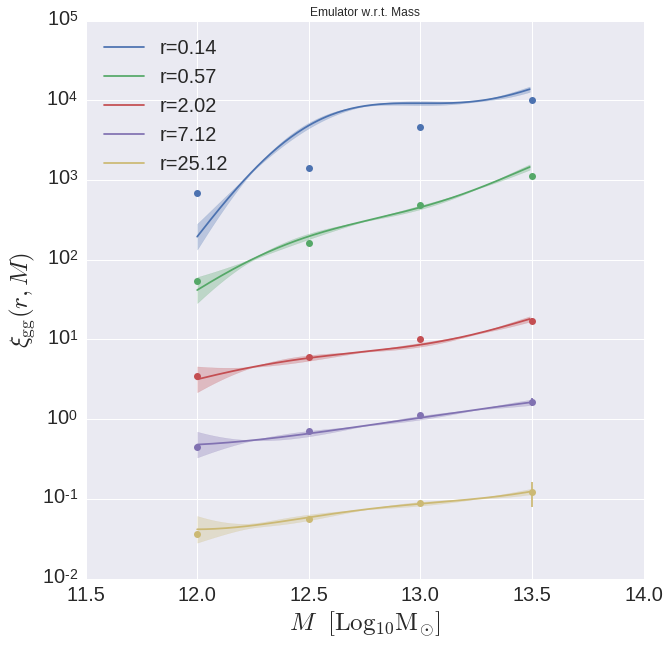

In [23]:
fig = plt.figure(figsize = (10, 10))
colors = cycle(sns.color_palette())

mass_list = np.arange(12,13.75, 0.25)
xi_of_m = {}

for m in mass_list:
    true_data = np.loadtxt(os.path.join(directory, 'corr_1.000_redMagic_mm_%.2f.npy'%m) )
    true_cov = np.loadtxt(os.path.join(directory,'cov_1.000_redMagic_mm_%.2f.npy'%m) )
    xi_of_m[m] = (true_data, true_cov)

num_skip = 4
for i, (_r, color) in enumerate(zip(r[0::num_skip],colors)):
    #t = np.stack([mass_list, np.ones_like(mass_list)*np.log10(_r)]).T
    dense_mass = np.arange(12.0, 13.5, 0.01)
    t = np.stack([dense_mass, np.ones_like(dense_mass)*np.log10(_r)]).T
    #t = np.stack([dense_mass, np.ones_like(dense_mass)*_r]).T

    y_hat = 0
    mu, cov = gp.predict(y-y_hat, t)
    std = np.sqrt(np.diag(cov))
    
    true_mu = np.array([xi_of_m[m][0].T[i*num_skip,1] for m in sorted(list(set(mass_list)-masses))])
    true_std = np.array([np.sqrt(xi_of_m[m][1][i*num_skip,i]) for m in sorted(list(set(mass_list)-masses))])

    #plt.errorbar(dense_mass, 10**(mu+y_hat), yerr = std, color = color, label = 'r=%.2f'%_r)
    plt.plot(dense_mass, 10**(mu+y_hat), color = color, label = 'r=%.2f'%_r)
    plt.fill_between(dense_mass,10**(mu+y_hat+std),10**(mu+y_hat-std), color = color, alpha = 0.3)

    #plt.errorbar(dense_mass, (mu+y_hat), yerr = std, color = color, label = 'r=%.2f'%_r)
    
    plt.errorbar(sorted(list(set(mass_list)-masses)), true_mu, yerr = true_std, fmt = 'o', color = color)
    
plt.xlim(xmin = 11.5, xmax = 14)
plt.ylim(ymin = 1e-2, ymax = 1e5)
plt.title('Emulator w.r.t. Mass')
plt.yscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel(r'$M $  $\rm{[Log_{10} M_{\odot}]}$', fontsize=25)
plt.ylabel(r'$\xi_{\rm gg}(r,M)$', fontsize=25)
plt.legend(loc='best', fontsize=20)  

plt.show()